<a href="https://colab.research.google.com/github/avichaljn97/tsai-eva6/blob/main/EVA-6_session3_MNIST_randomnumber_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
train_set = torchvision.datasets.MNIST(#creating the training set, it will give all 60000 data set in a single var 
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()#coverting the data in tensor form
        ,transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_set = torchvision.datasets.MNIST(#creating the training set, it will give all 60000 data set in a single var 
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()#coverting the data in tensor form
        ,transforms.Normalize((0.1307,), (0.3081,))
    ])
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#train_loader = torch.utils.data.DataLoader(train_set#DataLoader helps in forming batches and shuffling
#    ,batch_size=32
#    ,shuffle=True
#)

In [4]:
data_size = len(train_set)

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)#28*28*32
        self.pool1 = nn.MaxPool2d(2,2)#14*14*32

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)#14*14*64
        self.pool2 = nn.MaxPool2d(2,2)#7*7*128

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)#7*7*128

        self.GAP = nn.AvgPool2d(kernel_size=5)#1*1*256

        self.fc1 = nn.Linear(in_features=128 + 10, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.out1 = nn.Linear(in_features=32, out_features=10)
        self.out2 = nn.Linear(in_features=32, out_features=19)

    def forward(self, x,y): 

        x = self.pool1(F.relu(self.conv1(x)))
        
        x = self.pool2(F.relu(self.conv2(x)))

        x = self.GAP(F.relu(self.conv3(x)))

        #x = self.GAP(x)
        x = x.reshape(-1,128)
        
        x = torch.cat((x,y),dim=1)
        x = x.reshape(-1, 128 + 10)
        
        x = self.fc1(x)
        x = self.fc2(x)
        out1 = self.out1(x)
        out2 = self.out2(x)
        out1 = out1.reshape(-1,10)
        out2 = out2.reshape(-1,19)

 
        return F.log_softmax(out1, dim = 1),F.log_softmax(out2, dim = 1)

In [6]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
#batch=next(iter(train_loader))
#images,labels=batch
#network=Network()
#pred=network(images)
#pred.argmax(1)
#loss = F.nll_loss(pred, labels)
#loss.item()
#pred,labels

In [12]:
!pip install torchsummary 

from torchsummary import summary 

use_cuda = torch.cuda.is_available() 
# check if CUDA is available or not
# CUDA is a parallel computing platform for general computing on GPUs (graphics processing units)
# CUDA enables developers to speed up compute-intensive applications by using the power of GPUs for the parallelizable part of the computation.
 
device = torch.device("cuda" if use_cuda else "cpu") 
# use gpu if cuda is available
# else use cpu
network=Network()
network = network.to(device)
# pass the entire model to gpu if available or cpu if gpu is not available
 
#summary(mnist_model)

#print(network)
summary(network, input_size=[(1,28,28),(10,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 5, 5]          73,856
         AvgPool2d-6            [-1, 128, 1, 1]               0
            Linear-7                   [-1, 64]           8,896
            Linear-8                   [-1, 32]           2,080
            Linear-9                   [-1, 10]             330
           Linear-10                   [-1, 19]             627


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ignored

In [13]:
training_MNIST_loss, training_MNIST_accuracy, testing_MNIST_accuracy=[], [], []
training_sum_loss, training_sum_accuracy, testing_sum_accuracy=[], [], []


def train(network, device, train_loader, optimizer, epoch):
  total_loss1,total_loss2 = 0,0
  total_correct = 0
  total_sum_correct = 0
  loss = 0

  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    randDigits = torch.randint(0, 10, (100,))
    digOne = F.one_hot(randDigits, num_classes=10)
    randDigits = randDigits.to(device)
    digOne = digOne.to(device)
    
    preds, sum_preds = network(images, digOne) # Pass Batch
    loss1 = F.nll_loss(preds, labels) # Calculate Loss
    loss2 = F.nll_loss(sum_preds, labels+randDigits)
    
    loss =  ( loss1 + 2*loss2 ) 

    total_loss1 += loss1.item()
    total_loss2 += loss2.item()
    total_correct += get_num_correct(preds, labels)
    total_sum_correct += get_num_correct(sum_preds, labels + randDigits)

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights
  
  training_MNIST_loss.append(loss1.item())
  training_MNIST_accuracy.append(100*total_correct/data_size)
  training_sum_loss.append(loss2.item())
  training_sum_accuracy.append(100*total_sum_correct/data_size)

  print("Training: epoch %d total_correct:%.2f  total_sum_correct: %.2f" %(epoch ,100*total_correct/data_size ,100*total_sum_correct/data_size ))

def test (network, device, test_loader):
  network.eval()
  total_correct = 0
  total_sum_correct = 0
  processed = 0

  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      randDigits = torch.randint(0, 10, (100,))
      digOne = F.one_hot(randDigits, num_classes=10)
      randDigits = randDigits.to(device)
      digOne = digOne.to(device)
    
      preds, sum_preds = network(images, digOne)
      total_correct += get_num_correct(preds, labels)
      total_sum_correct += get_num_correct(sum_preds, labels + randDigits)
      processed += len(labels)

    testing_MNIST_accuracy.append(100*total_correct/processed)
    testing_sum_accuracy.append(100*total_sum_correct/processed)
    print("Testing: epoch %d total_correct:%.2f  total_sum_correct: %.2f" %(epoch ,100*total_correct/processed ,100*total_sum_correct/processed ))


In [14]:
torch.set_grad_enabled(True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

for epoch in range(0, 50):
    train(network, device, train_loader, optimizer, epoch)
    test(network, device, test_loader)

Training: epoch 0 total_correct:52.02  total_sum_correct: 19.62
Testing: epoch 0 total_correct:94.34  total_sum_correct: 38.38
Training: epoch 1 total_correct:95.34  total_sum_correct: 43.29
Testing: epoch 1 total_correct:97.03  total_sum_correct: 55.92
Training: epoch 2 total_correct:97.39  total_sum_correct: 54.21
Testing: epoch 2 total_correct:98.31  total_sum_correct: 51.41
Training: epoch 3 total_correct:98.12  total_sum_correct: 59.44
Testing: epoch 3 total_correct:98.34  total_sum_correct: 61.17
Training: epoch 4 total_correct:98.56  total_sum_correct: 64.23
Testing: epoch 4 total_correct:98.71  total_sum_correct: 65.44
Training: epoch 5 total_correct:98.64  total_sum_correct: 67.34
Testing: epoch 5 total_correct:98.76  total_sum_correct: 67.64
Training: epoch 6 total_correct:98.90  total_sum_correct: 68.78
Testing: epoch 6 total_correct:98.87  total_sum_correct: 69.43
Training: epoch 7 total_correct:98.96  total_sum_correct: 70.75
Testing: epoch 7 total_correct:99.04  total_sum

Text(0.5, 1.0, 'Test Sum Accuracy')

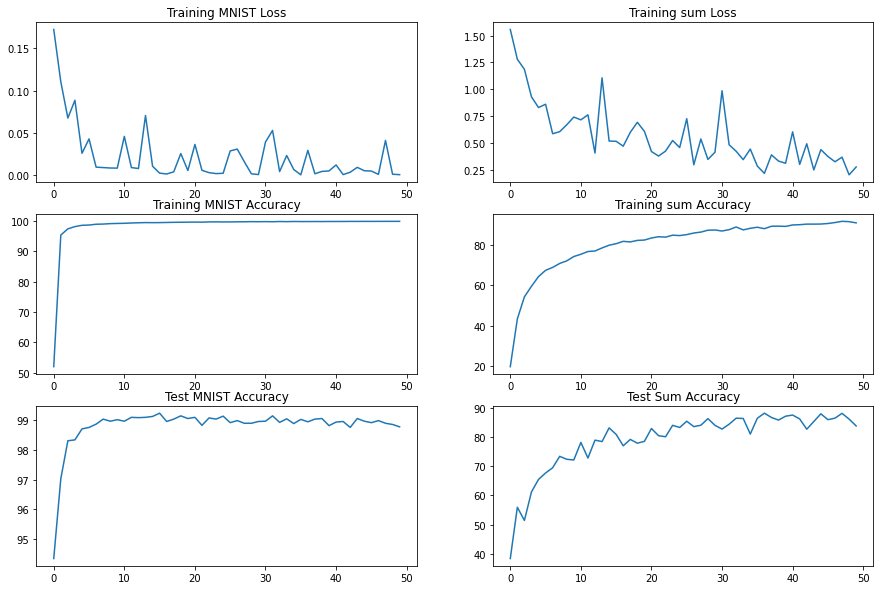

In [15]:
fig, axs = plt.subplots(3,2,figsize=(15,10))
axs[0, 0].plot(training_MNIST_loss)
axs[0, 0].set_title("Training MNIST Loss")
axs[1, 0].plot(training_MNIST_accuracy)
axs[1, 0].set_title("Training MNIST Accuracy")
axs[0, 1].plot(training_sum_loss)
axs[0, 1].set_title("Training sum Loss")
axs[1, 1].plot(training_sum_accuracy)
axs[1, 1].set_title("Training sum Accuracy")
axs[2, 0].plot(testing_MNIST_accuracy)
axs[2, 0].set_title("Test MNIST Accuracy")
axs[2, 1].plot(testing_sum_accuracy)
axs[2, 1].set_title("Test Sum Accuracy")